In [3]:
from pyhdf.SD import SD, SDC, SDS
from pyhdf.HDF import *
from pyhdf.VS import *
import pyart
import glob
from dask import bag as db
from netCDF4 import Dataset
from scipy import ndimage
from matplotlib.collections import LineCollection
from datetime import datetime, timedelta
%pylab inline


## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119



/home/rjackson/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


Populating the interactive namespace from numpy and matplotlib


/blues/gpfs/home/rjackson/anaconda3/envs/yt_devel/lib/python3.6/site-packages/ipython-6.5.0-py3.6.egg/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['datetime']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [4]:
file_path = '/lcrc/group/earthscience/rjackson/cloudsat/2007063042216_04512_CS_2B-GEOPROF_GRANULE_P_R04_E02.hdf'
cpol_file_path = '/lcrc/group/earthscience/rjackson/echo_tops/echo_tops_70km_1000m/2007/20070304/echo_tops_200703040500.cdf'

In [5]:
f = HDF(path=file_path, mode=SDC.READ)
vs = f.vstart()
vdata_lat = vs.attach('Latitude')
vdata_long = vs.attach('Longitude')
time = vs.attach('Profile_time')
UTC_start = vs.attach('UTC_start')
TAI_start = vs.attach('TAI_start')
cpr_echo_top = vs.attach('CPR_Echo_Top')
lat = np.array(vdata_lat[:])
lon = np.array(vdata_long[:])
time = time[:]
cpr_echo_top = cpr_echo_top[:]
TAI_start = TAI_start[:]
UTC_start = UTC_start[:]
data_info_list = vs.vdatainfo()

vs.end() # terminate the vdata interface
f.close()


HDF4Error: close (42): There are still active AIDs

In [ ]:
dset = SD(path=file_path, mode=SDC.READ)
datasets_dic = dset.datasets()
print(dset.datasets())
ref = dset.select('Radar_Reflectivity')
mask = dset.select('CPR_Cloud_mask')
mask = mask.get()
height = dset.select('Height')
height = height.get()
attr_dict = ref.attributes()
ref_array = ref.get()
min_valid = attr_dict['valid_range'][0]
max_valid = attr_dict['valid_range'][1]
ref_array = np.ma.masked_where(np.logical_or.reduce((ref_array <= min_valid, ref_array >= max_valid, mask < 25)), ref_array)

In [ ]:
print(lat.shape)
print(dset.datasets().keys())

In [ ]:
array_shape = height.shape
#cloud_top = np.zeros(array_shape[0])
y_values, x_values = np.meshgrid(range(0, array_shape[0]), range(0, array_shape[1]), indexing='ij')
labels = y_values

height_masked = np.ma.masked_where(ref_array.mask == True, height)
cloud_top = np.ma.max(height_masked, axis=1, fill_value=-9999.0)
print(cloud_top)
any_cloud = np.any(mask > 25, axis=1)
last_cloud = mask[:,-1] > 25
geographical_region = np.squeeze(np.logical_and.reduce((lat > -13.25, lat < -11.25, lon > 130, lon < 132)))
print(np.logical_or(any_cloud == False, geographical_region.T == False))
#cloud_top = np.ma.masked_where(np.logical_or(any_cloud == False, geographical_region == False), cloud_top)
plt.plot(cloud_top)

In [ ]:
new_ref = ref_array[~np.logical_or(any_cloud == False, geographical_region == False), :].T/100.0
new_h = height[~np.logical_or(any_cloud == False, geographical_region == False), :].T
new_lon = lon[~np.logical_or(any_cloud == False, geographical_region == False)]
new_lat = lon[~np.logical_or(any_cloud == False, geographical_region == False)]
new_ctop = cloud_top[~np.logical_or(any_cloud == False, geographical_region == False)]
lon_tile = np.tile(new_lon, [1, new_ref.shape[0]])
plt.pcolormesh(lon_tile.T, new_h, new_ref, cmap='pyart_HomeyerRainbow')
plt.plot(new_lon, new_ctop, linewidth=3, color='k')
plt.colorbar(label='Reflectivity')

In [ ]:
print(int(TAI_start[0][0]))
python_times = timedelta(seconds=int(TAI_start[0][0])) + np.array([datetime.datetime(1993,1,1) +timedelta(seconds=x[0]) for x in time])
print(python_times[~np.logical_or(any_cloud == False, geographical_region == False)])

In [ ]:
echo_top_dset = Dataset(cpol_file_path)
lat_echo = echo_top_dset.variables['lat'][:,:]
lon_echo = echo_top_dset.variables['lon'][:,:]
eth = echo_top_dset.variables['ETH'][:,:]

lat1d = lat_echo[:,1]
lon1d = lon_echo[1,:]
eth_cpol = np.zeros(new_ctop.shape)
for i in range(len(new_lon)):
    j_ind = np.argmin(np.abs(new_lon[i]-lon1d))
    i_ind = np.argmin(np.abs(new_lat[i]-lat1d))
    eth_cpol[i] = eth[i_ind, j_ind]
cloud_sat_data_mask = ~np.logical_or(any_cloud == False, geographical_region == False)
plt.pcolormesh(lon_echo, lat_echo, eth)
plt.colorbar(label='ETH [m]')
plt.scatter(lon[cloud_sat_data_mask], lat[cloud_sat_data_mask])

In [ ]:
plt.scatter(eth_cpol/1e3, new_ctop/1e3)
plt.ylabel('CloudSat ETH [km]')
plt.xlabel('CPOL ETH [km]')
plt.xlim([0, 20])
plt.ylim([0, 20])
plt.plot([0, 20], [0, 20], color='k')

In [75]:
def get_eth_cloudsat_and_cpol(file):
    #try:
    f = HDF(path=file, mode=SDC.READ)
    vs = f.vstart()
    vdata_lat = vs.attach('Latitude')
    vdata_long = vs.attach('Longitude')
    time = vs.attach('Profile_time')
    UTC_start = vs.attach('UTC_start')
    TAI_start = vs.attach('TAI_start')
    lat = np.array(vdata_lat[:])
    lon = np.array(vdata_long[:])
    time = time[:]
    TAI_start = TAI_start[:]
    UTC_start = UTC_start[:]
    data_info_list = vs.vdatainfo()
        

    vs.end() # terminate the vdata interface
    #f.close()
    #except:
    #    return [], []
    # Load SDS datasets
    dset = SD(path=file, mode=SDC.READ)
    datasets_dic = dset.datasets()
    ref = dset.select('Radar_Reflectivity')
    mask = dset.select('CPR_Cloud_mask')
    mask = mask.get()
    height = dset.select('Height')
    height = height.get()
    attr_dict = ref.attributes()
    ref_array = ref.get()
    min_valid = -5000.0
    max_valid = 6000.0
    ref_array = np.ma.masked_where(np.logical_or.reduce((ref_array <= min_valid, ref_array >= max_valid, mask < 25)), ref_array)
    
    # Get cloud top heights assuming "good echoes"
    array_shape = height.shape
    #cloud_top = np.zeros(array_shape[0])
    y_values, x_values = np.meshgrid(range(0, array_shape[0]), range(0, array_shape[1]), indexing='ij')
    labels = y_values

    height_masked = np.ma.masked_where(ref_array.mask == True, height)
    cloud_top = np.ma.max(height_masked, axis=1, fill_value=-9999.0)

    any_cloud = np.any(mask > 25, axis=1)
    last_cloud = mask[:,-1] > 25
    geographical_region = np.squeeze(np.logical_and.reduce((lat > -13.25, lat < -11.25, lon > 130, lon < 132)))

    new_ref = ref_array[~np.logical_or(any_cloud == False, geographical_region == False), :].T/100.0
    new_h = height[~np.logical_or(any_cloud == False, geographical_region == False), :].T
    new_lon = lon[~np.logical_or(any_cloud == False, geographical_region == False)]
    new_lat = lon[~np.logical_or(any_cloud == False, geographical_region == False)]
    new_ctop = cloud_top[~np.logical_or(any_cloud == False, geographical_region == False)]
    
    # Now we get the closest CPOL scan
    python_times = timedelta(seconds=int(TAI_start[0][0])) + np.array([datetime.datetime(1993,1,1) +timedelta(seconds=x[0]) for x in time])
    try:
        the_time = python_times[~np.logical_or(any_cloud == False, geographical_region == False)][0]
    except IndexError:
        return np.ma.array(np.nan), np.ma.array(np.nan)
    
    year = '%4d' % the_time.year
    month = '%02d' % the_time.month
    day = '%02d' % the_time.day
    hour = '%02d' % the_time.hour
    minute = '%02d' % the_time.minute
    print(the_time)
    
    cpol_eth_file = ('/lcrc/group/earthscience/rjackson/echo_tops/echo_tops_70km_1000m_ref/' + 
                     year + '/' + year + month + day + '/' + 'echo_tops_' + year + month + 
                     day + hour + minute[0] + '0.cdf')
    echo_top_dset = Dataset(cpol_file_path)
    lat_echo = echo_top_dset.variables['lat'][:,:]
    lon_echo = echo_top_dset.variables['lon'][:,:]
    eth = echo_top_dset.variables['ETH'][:,:]

    lat1d = lat_echo[:,1]
    lon1d = lon_echo[1,:]
    eth_cpol = np.zeros(new_ctop.shape)
    for i in range(len(new_lon)):
        j_ind = np.argmin(np.abs(new_lon[i]-lon1d))
        i_ind = np.argmin(np.abs(new_lat[i]-lat1d))
        eth_cpol[i] = eth[i_ind, j_ind]
    return new_ctop, eth_cpol


Loading /lcrc/group/earthscience/rjackson/cloudsat/2016008042414_51583_CS_2B-GEOPROF_GRANULE_P_R04_E06.hdf
2016-01-08 05:10:14.040039


/blues/gpfs/home/rjackson/anaconda3/envs/yt_devel/lib/python3.6/site-packages/ipykernel_launcher.py:83: UserWarning: Warning: converting a masked element to nan.


Loading /lcrc/group/earthscience/rjackson/cloudsat/2009340042434_19191_CS_2B-GEOPROF_GRANULE_P_R04_E02.hdf
2009-12-06 05:10:59.718994
Loading /lcrc/group/earthscience/rjackson/cloudsat/2015365164548_51474_CS_2B-GEOPROF_GRANULE_P_R04_E06.hdf
Loading /lcrc/group/earthscience/rjackson/cloudsat/2010031164552_20014_CS_2B-GEOPROF_GRANULE_P_R04_E03.hdf
Loading /lcrc/group/earthscience/rjackson/cloudsat/2007014164932_03806_CS_2B-GEOPROF_GRANULE_P_R04_E02.hdf
2007-01-14 16:52:44.240005
Loading /lcrc/group/earthscience/rjackson/cloudsat/2012075164306_31289_CS_2B-GEOPROF_GRANULE_P_R04_E05.hdf
Loading /lcrc/group/earthscience/rjackson/cloudsat/2015125164643_47979_CS_2B-GEOPROF_GRANULE_P_R04_E06.hdf
Loading /lcrc/group/earthscience/rjackson/cloudsat/2015085042448_47389_CS_2B-GEOPROF_GRANULE_P_R04_E06.hdf
2015-03-26 05:10:47.800049
Loading /lcrc/group/earthscience/rjackson/cloudsat/2010343042216_24550_CS_2B-GEOPROF_GRANULE_P_R04_E03.hdf
2010-12-09 05:08:15.159912
Loading /lcrc/group/earthscience/rja

2007-01-31 05:07:55.159912
Loading /lcrc/group/earthscience/rjackson/cloudsat/2010096041747_20953_CS_2B-GEOPROF_GRANULE_P_R04_E03.hdf
Loading /lcrc/group/earthscience/rjackson/cloudsat/2007071164356_04636_CS_2B-GEOPROF_GRANULE_P_R04_E02.hdf
Loading /lcrc/group/earthscience/rjackson/cloudsat/2013360041813_40763_CS_2B-GEOPROF_GRANULE_P_R04_E06.hdf
Loading /lcrc/group/earthscience/rjackson/cloudsat/2014354042438_45991_CS_2B-GEOPROF_GRANULE_P_R04_E06.hdf
2014-12-20 05:10:45.838989
Loading /lcrc/group/earthscience/rjackson/cloudsat/2006172042034_00784_CS_2B-GEOPROF_GRANULE_P_R04_E00.hdf
2006-06-21 05:06:46.879883
Loading /lcrc/group/earthscience/rjackson/cloudsat/2012030165000_30633_CS_2B-GEOPROF_GRANULE_P_R04_E05.hdf
Loading /lcrc/group/earthscience/rjackson/cloudsat/2012365042405_35506_CS_2B-GEOPROF_GRANULE_P_R04_E06.hdf
2012-12-30 05:10:13
Loading /lcrc/group/earthscience/rjackson/cloudsat/2010054165201_20349_CS_2B-GEOPROF_GRANULE_P_R04_E03.hdf
2010-02-23 16:55:14.240005
Loading /lcrc/gr

Loading /lcrc/group/earthscience/rjackson/cloudsat/2013056041833_36336_CS_2B-GEOPROF_GRANULE_P_R04_E06.hdf
Loading /lcrc/group/earthscience/rjackson/cloudsat/2013359164602_40756_CS_2B-GEOPROF_GRANULE_P_R04_E06.hdf
Loading /lcrc/group/earthscience/rjackson/cloudsat/2015052165247_46916_CS_2B-GEOPROF_GRANULE_P_R04_E06.hdf
Loading /lcrc/group/earthscience/rjackson/cloudsat/2016064164600_52406_CS_2B-GEOPROF_GRANULE_P_R04_E06.hdf
Loading /lcrc/group/earthscience/rjackson/cloudsat/2013040041823_36103_CS_2B-GEOPROF_GRANULE_P_R04_E06.hdf
Loading /lcrc/group/earthscience/rjackson/cloudsat/2012019041628_30465_CS_2B-GEOPROF_GRANULE_P_R04_E05.hdf
Loading /lcrc/group/earthscience/rjackson/cloudsat/2007008041536_03711_CS_2B-GEOPROF_GRANULE_P_R04_E02.hdf
Loading /lcrc/group/earthscience/rjackson/cloudsat/2006309041529_02779_CS_2B-GEOPROF_GRANULE_P_R04_E02.hdf
Loading /lcrc/group/earthscience/rjackson/cloudsat/2015062041845_47054_CS_2B-GEOPROF_GRANULE_P_R04_E06.hdf
Loading /lcrc/group/earthscience/rjac

Loading /lcrc/group/earthscience/rjackson/cloudsat/2012121164805_31960_CS_2B-GEOPROF_GRANULE_P_R04_E05.hdf
Loading /lcrc/group/earthscience/rjackson/cloudsat/2011345164528_29904_CS_2B-GEOPROF_GRANULE_P_R04_E05.hdf
Loading /lcrc/group/earthscience/rjackson/cloudsat/2012050042046_30917_CS_2B-GEOPROF_GRANULE_P_R04_E05.hdf
2012-02-19 05:06:43.078979
Loading /lcrc/group/earthscience/rjackson/cloudsat/2010103042353_21055_CS_2B-GEOPROF_GRANULE_P_R04_E03.hdf
2010-04-13 05:09:51.519043
Loading /lcrc/group/earthscience/rjackson/cloudsat/2014090164627_42154_CS_2B-GEOPROF_GRANULE_P_R04_E06.hdf
Loading /lcrc/group/earthscience/rjackson/cloudsat/2014011041810_40996_CS_2B-GEOPROF_GRANULE_P_R04_E06.hdf
Loading /lcrc/group/earthscience/rjackson/cloudsat/2015094041839_47520_CS_2B-GEOPROF_GRANULE_P_R04_E06.hdf
Loading /lcrc/group/earthscience/rjackson/cloudsat/2016039165159_52042_CS_2B-GEOPROF_GRANULE_P_R04_E06.hdf
Loading /lcrc/group/earthscience/rjackson/cloudsat/2010342165004_24543_CS_2B-GEOPROF_GRANU

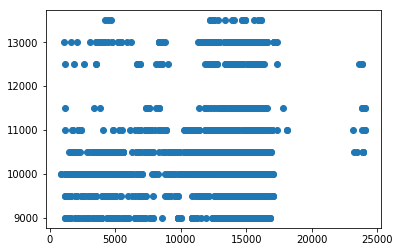

In [80]:
file_list = glob.glob('/lcrc/group/earthscience/rjackson/cloudsat/*.hdf')
new_ctops = []
eth_cpols = []
the_bag = db.from_sequence(file_list)
for the_file in file_list:
    print('Loading ' + the_file)
    new_ctop, eth_cpol = get_eth_cloudsat_and_cpol(the_file)
    if(not np.all(np.isnan(new_ctop)) and not np.all(np.isnan(eth_cpol))):
        new_ctops.append(new_ctop)
        eth_cpols.append(eth_cpol)

new_ctops = np.concatenate(new_ctops)
eth_cpols = np.concatenate(eth_cpols)
plt.scatter(new_ctops, eth_cpols)

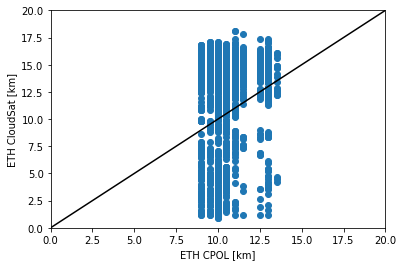

In [83]:
#new_ctops = np.concatenate(new_ctops)
#eth_cpols = np.concatenate(eth_cpols)
plt.scatter(eth_cpols/1e3, new_ctops/1e3)
plt.xlim([0, 20])
plt.ylim([0, 20])
plt.xlabel('ETH CPOL [km]')
plt.ylabel('ETH CloudSat [km]')
plt.plot([0, 20], [0, 20], color='k')

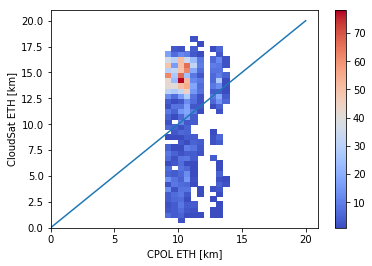

In [84]:
hist, bins_x, bins_y = np.histogram2d(eth_cpols/1e3, new_ctops/1e3, bins=np.arange(0, 20, 0.5))
x, y = np.meshgrid(bins_x, bins_y)
hist[hist == 0] = np.nan
plt.pcolormesh(x,y, hist.T, cmap='coolwarm')
plt.xlabel('CPOL ETH [km]')
plt.ylabel('CloudSat ETH [km]')
plt.colorbar()
plt.plot([0, 20], [0, 20])

In [85]:
print(np.nansum(hist))

2386.0
